# Neural Potential Tutorial

<b>TL;DR</b> Neural Potentials and neural ordinary differential equations are awesome. To immediately see how they are implemented, move to part three.

This Julia notebook intents to cover the basics of the neural potential method which combines the power of neural ordinary differential equations with the physical concept of potentials.
The notebook assumes that you have some familiarity with neural networks, differential equations and the basic concepts of physics,  in particular mechanics.
It is devided into three major parts.
In part one, we will explore what potentials actually are and why they are so important to physics.
In the second part, we will introduce the concept of neural ordinary differential equations.
After that, the third part will combine this knowledge to construct the approach of neural potentials and we will analyze a non-trivial potential problem with it.
The notebook is written in Julia because Julia offers a nicely written and easy-to-use interface facilitates the use of neural ordinary differential equations for scientific applications.
If you are familiar with the programming language Python, the following websites might help to kickstart your Julia skills:
- Simple introduction: https://sunscrapers.com/blog/the-quickest-introduction-to-julia-for-pythonistas/
- Appendix of Julia Language:  https://docs.julialang.org/en/v1/manual/noteworthy-differences/

## Part One - What is a Potential?

Potentials are one of the elementary concepts in physics that is especially for classical mechanics, quantum mechanics and particle physics.
The potential is the quantity that actually defines the "actual physics" of the object we are investigating as opposed to the "dynamics" which essentially tells us something about the state of motion our object.
If you are a physicist or if you are already familiar with Lagrangian or Hamiltonian mechanics due to some other obscure reason (I highly doubt that any other profession besides physicists and mathematicians requires knowledge of this concept), then I recommend you to skip this section as it is only a crude repetition of what you should already know.<br>
Anyways, the potential is a concept that is well established within physics for centurys.
Take a mass $m$ on a spring as an example. We will neglect the nuisances of friction and non-linear effects. 
In that case, we know from school, intuition or any other source that the mass will perform periodic motions which we can plot nicely as sinusoidal curves.
The curves are solutions to the following differential equation that we can set up by combining Newton's second law
$ m \ddot{x} = F $ and Hooke's law, which tells us that the acceleration of the spring is proportional to its displacement, i.e. $ F = -Dx $ where $D$ is called the spring constant.
Note that Hooke's law contains the actual physics, i.e. it tells us what kind of physical effect we observe and the forces that act on our mass.
Newton's law only tells us that we deal with an acceleration that is due to the acting forces, i.e. it only describes the dynamics.
We find that the differential equation looks like

\begin{equation}
	m \ddot{x} = -Dx.
\end{equation}

For this system, energy is conserved because there is no loss of energy due to friction or other dissipassive effects. 
Thus, an alternative description is provided by considering the total energy of the system $E$ which is given as the sum of kinetic energy $T$ and potential energy $V$.<br>
The kinetic energy reads $T = \frac{1}{2}m\dot{x}^2$. The potential energy, i.e. the system posses which con potentially be converted into work , is given by integrating the acting force $F$:

\begin{equation}
    V = -\int F \cdot \mathrm{d}x = \dfrac{1}{2}Dx^2
\end{equation}

Thus, the total energy of our mass-spring system reads

\begin{equation}
    E = \dfrac{1}{2}m \dot{x}^2 + \dfrac{1}{2}Dx^2.
\end{equation}

The total energy needs to be conserved for all times, such that we have $ \frac{\mathrm{d}E}{\mathrm{d}t} = 0 $.
Using this relation and deriving both parts on the right side of the conservation equation gives us back the differential equation given above which we found by combining Newton's law and Hooke's law:

\begin{equation}
    0 = \Big( m\ddot{x} + Dx \Big)\dot{x}
\end{equation}

In a more general setting, where we would have an arbitrary potential energy that does not directly depend on time $t$, i.e. $ \frac{\partial V}{\partial t} = 0 $, we find that this gives

\begin{equation}
    m \ddot{x} = -\dfrac{\mathrm{d}V(x)}{\mathrm{d}x}.
\end{equation}

By virtue of the equation of total energy, $ \frac{\partial V}{\partial t} = 0 $ is equivalent to conservation of total energy as the kinetic energy does not explicitly depend on time.
We call the quantity $V(x)$ the <b>potential</b> of our system. It essentially describes the potential energy of our system, but this interpretation is not always correct for every system.
Thus, we see that the shape of the potential defines the physics of our system. <br>
However, it is important to mention that this holds only for <b >energy-conserving systems</b>!
This also already shows one of the limitations of the method of neural potentials.

## Part Two - Neural Ordinary Differential Equations

### What is a Neural Differential Equation?

Neural ordinary differential equations are a very recent development in the area of machine learning and artificial intelligence.
They are the continuous generalization of residual neural networks, which use a hidden state $\mathbf{h}_t$ to store information about the current state of the network and its inputs to be able to reuse it later within the network.
Residual neural networks are equivalent to recurrent neural networks that are often used in time-series analysis, is also the problem we are trying to solve.
Both can be written as a sequence of discrete transformations that is applied to the hidden state:

\begin{equation}
	\mathbf{h}_{t+1} = \mathbf{h}_t + f(\mathbf{h}_t, \theta_t)
\end{equation}

This equation is similar to the Euler discretization of an ordinary differential equation (ODE) of the form 

\begin{equation}
	\label{neuraldifferentialequation}
	\dfrac{\mathrm{d}\mathbf{h}(t)}{\mathrm{d}t} = f(\mathbf{h}(t), \theta, t).
\end{equation}

If we take $\mathbf{h}(0)$ to be the input layer, then we can compute the output layer $\mathbf{h}(T)$ by solving of the initial value problem given above using a numerical differential equation solver.
By using an adaptive solver, the model evaluates the hidden dynamics $f$ where necessary by itself with the desired accuracy.
In particular, this allows the model evaluation to scale with the problem complexity.
When training a machine learning model, it is necessary to have an algorithm that allows to adjust the parameters with respect to some cost function.
The method of choice for this is usually backpropagation.<br>
For a differential equation it is possible to back-propagate through the operations of the solver, but then memory cost and evaluation time scale directly with the number of model evaluations and it is necessary to know the internal workings of the ODE solver.
Another method to compute the gradients is called the \textit{adjoint sensitivity method}.
This method defines a second, augmented ODE that is solved backwards in time and gives the gradient of the cost function and model with respect to the hidden state and parameters.
This approach has multiple advantages:

* The ODE solver is treated as a black box, i.e. internal workings are no longer relevant.
* Forward pass and backward pass can be done using the same ODE solver.
* It scales linearly with the problem size and has low memory cost.
* The numerical error is controlled explicitly.
* Initial conditions can also be included as trainable parameters.

### Adjoint Sensitivity or How to Calculate Gradients

The forward pass of the model consists of plugging the solution of the ODE into the cost function $\mathcal{L}$:

\begin{equation}
    \label{costfunction}
    \mathcal{L}(\mathbf{h}(T)) = \mathcal{L}\Bigg( \mathbf{h}(0) + \int_0^T f(\mathbf{h}(t), \theta, t)\mathrm{d}t \Bigg).
\end{equation}

To construct the augmented ODE, we introduce the adjoint $\mathbf{a}(t) = \frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\mathbf{h}(t)}$ that describes how the cost function changes with the hidden state.
Differentiating the cost function with respect to the time $t$ and rewriting the terms as derivatives with respect to the hidden state $\mathbf{h}$ yields the ODE for the adjoint:

\begin{equation}
    \dfrac{\mathrm{d}\mathbf{a}(t)}{\mathrm{d}t} = - \mathbf{a}(t)^\intercal \dfrac{\partial f(\mathbf{h}(t), \theta, t)}{\partial \mathbf{h}}.
\end{equation}

The interesting quantity is $\mathbf{a}(0) = \frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\mathbf{h}(0)}$, which is equivalent to gradient at the input layer after back-propagating through all intermediate layers.
To compute this, the  has to be solved backwards with the initial value $\frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\mathbf{h}(T)}$.
However, to solve this ODE the values of $\mathbf{h}(t)$ needs to be known at all intermediate evaluation times.
They can be obtained by solving the ODE given above backwards in time with the initial value $ \mathbf{h}(T)$ that is known from the forward pass.<br>
Last but not least, we need to include the gradients of the cost function with respect to the model parameters, that is $\frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\theta}$.
Deriving the cost function given above with respect to the parameters $\theta$ gives the corresponding differential equation:

\begin{equation}
    \mathbf{g}(t) = \frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\theta} = - \int_{T}^{0} \mathbf{a}(t)^\intercal\dfrac{\partial f(\mathbf{h}(t), \theta, t)}{\partial \theta} \mathrm{d}t.
\end{equation}

Taking the three quantities together allows us to construct an augmented ODE with the state vector $(\mathbf{h}(t), \mathbf{a}(t), \mathbf{g}(t))$:

\begin{equation}
    \begin{aligned}
        &\dfrac{\mathrm{d}\mathbf{h}}{\mathrm{d}t} = f(\mathbf{h}(t), \theta, t) \\
        &\dfrac{\mathrm{d}\mathbf{a}}{\mathrm{d}t} = - \mathbf{a}(t)^\intercal \dfrac{\partial f(\mathbf{h}(t), \theta, t)}{\partial \mathbf{h}} \\
        &\dfrac{\mathrm{d}\mathbf{g}}{\mathrm{d}t} =  - \mathbf{a}(t)^\intercal \dfrac{\partial f(\mathbf{h}(t), \theta, t)}{\partial \theta}
    \end{aligned}
\end{equation}

The solution of the initial value problem with the initial conditions $(\mathbf{h}(0), \frac{d\mathcal{L}}{d\mathbf{h}(T)}, \mathbf{0})$ then gives the gradients $\frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\mathbf{h}(0)}$ and $\frac{\mathrm{d}\mathcal{L}}{\mathrm{d}\theta}$, that in turn can be used to adjust the model parameters accordingly.
It should be mentioned that this approach of constructing an adjoint for gradient computations works only for ordinary differential equations.
The original paper now just replaces $f$ with a neural network with the appropriate number of input and output neurons. <br>
The hidden layers can be fully connected or convolutional or something else, as long as it is differentiable.
In this way, we essentially construct a continuous-depth recurrent neural network, where the solver, decides how many evaluations it needs for every time-step.
In this way, the solver adjusts the depth of the recurrent neural network to the complexity of the problem.
For more information on neural differential equations, see the original paper, the youtube video and some other sources:
* Paper on arxiv.org: https://arxiv.org/pdf/1806.07366.pdf
* Youtube video: https://www.youtube.com/watch?v=jltgNGt8Lpg
* Another good article: https://towardsdatascience.com/neural-odes-breakdown-of-another-deep-learning-breakthrough-3e78c7213795
* Neural ODEs in Julia: https://julialang.org/blog/2019/01/fluxdiffeq/

The key takeaway here is not the full bunch of formulas, but rather the fact that the loss and the gradient of the parameters with respect to the loss function can be computed in a single pass to the ODE solver just by solving this complicated ODE that is shown above. 
Luckily, the Julia package will take care of all that such that we will only have to perform a single function call to do all the presented magic of adjont sensitivity.

## Part Three - Neural Potentials

So what is the neural potential approach? Typically, a neural ordinary differential equation is constructed by replacing the function $f$ on the left side by some sort of neural network which has as many input neurons as there are state variables and it also has an equal amount of output neurons, i.e. we only have a neural network on the right side which has to accomodate for all the dynamics and behaviour of our machine learning model:

IMAGE HERE!

The idea of neural potentials is to use prior knowledge about the system like symmetries or conservation laws
by explicitely implementing them into the differential equation.
As an example, we look again at our mass on a spring. The first thing that catches our eye is that it is a <b> second order ODE</b>, but neural ordinary differential equations require the system to only contain first order time derivatives! This problem is circumvented by introducting the auxiliary variable $\upsilon(t) = \dot{x}(t)$.
Then, the second order ODE can be rewritten into a system of coupled first order differential equations:

\begin{equation}
    \begin{aligned}
        &\dfrac{\mathrm{d}x(t)}{\mathrm{d}t} = \upsilon(t) \\
        &\dfrac{\mathrm{d}\upsilon(t)}{\mathrm{d}t} = -\dfrac{\mathrm{d}V(x)}{\mathrm{d}x} \\
    \end{aligned}
\end{equation}

Now we have two state variables $x$ and $\upsilon$, which is essentially the velocity of the mass. For simplicity, we set the mass $m = 1$. Now in the case of a typical neural ODE, we would replace the right side by a neural network with two inputs and two outputs $\mathrm{\mathbf{NN}}(x, \upsilon; \theta)$, which is essentially a two-component vector field with a set of parameters $\theta$:

\begin{equation}
    \begin{aligned}
        &\dfrac{\mathrm{d}x(t)}{\mathrm{d}t} = \mathrm{NN}_1(x, \upsilon; \theta) \\
        &\dfrac{\mathrm{d}\upsilon(t)}{\mathrm{d}t} = \mathrm{NN}_2(x, \upsilon; \theta) \\
    \end{aligned}
\end{equation}

Although this is a completely viable approach that has proven useful for plenty of applications in all areas of machine learning and artificial intelligence, it is hard to exactly understand what the neural network is learning and thus it does not offer a interpretation in terms of physical quantities.<br>
Thus, we go down a different road and only replace the potential by a neural network with one input neuron and one output neuron, i.e. $V(x) = \mathrm{NN}(x;\theta)$:

\begin{equation}
    \begin{aligned}
        &\dfrac{\mathrm{d}x(t)}{\mathrm{d}t} = \upsilon(t) \\
        &\dfrac{\mathrm{d}\upsilon(t)}{\mathrm{d}t} = -\dfrac{\mathrm{d}\mathrm{NN}(x;\theta) }{\mathrm{d}x} \\
    \end{aligned}
\end{equation}

This approach has several nice features. First of all, 

We start by by importing the relevant Julia packages such as the differential equations solvers, 
the deep learning package Flux and it's extension towards neural differential equations called DiffEqFlux as well as the automatic differentiation package Zygote.<br>
Zygote has the problem that it 

In [325]:
using DifferentialEquations
using Flux
using DiffEqFlux
using Zygote

Next, we import relevant other tools such as the Plots package and the LaTeXStrings package or the Statistics and Distributions packages.

In [326]:
using Plots
using LaTeXStrings
using Measures
using Statistics
using Distributions

Now we have to generate some harmonic oscillator data. 
We choose initial conditions of $x(0) = 3$ and $\upsilon(0) = 0$ over the interval $[0,5]$.
The oscillator has the parameters $D=2$ and $m=1$. We ignore the mass for the remainder of the notebook.

In [327]:
tspan = (0.0, 5.5)
t = Array(range(tspan[1], tspan[2], length=384))
u0 = [3.0, 0.0]
D = 2.0
p = [D]

1-element Vector{Float64}:
 2.0

Then, the potential of a simple harmonic oscillator is a parabolic potential. 
As we can see, we have to take the gradient of this potential to obtain the force.
In Julia, this can be done with ```Zygote.gradient(...)```.
The one in square brackets at the end indicates that we want the first entry of the tuple returned.
The gradient is returned as a tuple due to the fact how gradients are implemented in Julia. 
Look up the word pullback, if you want to know more.

In [328]:
V(x,p) = 0.5*p[1]*x^2
dV(x,p) = Zygote.gradient(x -> V(x,p), x)[1]

dV (generic function with 1 method)

Next, we have to define our differential equation in such a way that Julia's differential equations solver can understand it. There are multiple possibilities, but for our purpose the <b>in-place</b> variant is the most useful one, because it makes the conversion into a system of coupled first-order ODEs obvious:

In [329]:
function oscillator!(du, u, p, t)
    x = u[1]
    v = u[2]

    du[1] = v
    du[2] = -dV(x,p)[1]
end

oscillator! (generic function with 1 method)

Now we use the differential equations package to solve the initial value problem (IVP), which can be formulated through

In [330]:
ivp = ODEProblem(oscillator!, u0, tspan, p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 5.5)
u0: 2-element Vector{Float64}:
 3.0
 0.0

Now we solve the differential equation by just calling the ``` solve(...) ```-method. It returns an 2x256 array containing the solution of the ODE for $x(t)$ and $\upsilon(t)$. The keyword <i>Tsit5()</i> specifies the use of an adaptive Runge-Kutta 5/4 scheme to solve the ODE, i.e. it tells Julia which of the myriards of possible algorithms to use.
The array $t$ specifies the points where we want to know the solution. Be sure to choose enought points because otherwise the solver will crash as there are not enough intermediate timesteps available.

In [331]:
solution = Array(solve(ivp, Tsit5(), saveat=t))

2×384 Matrix{Float64}:
 3.0   2.99938    2.99753    2.99443   …   0.348085   0.287497   0.226794
 0.0  -0.086156  -0.172276  -0.258326     -4.2142    -4.22333   -4.23071

We do a short sanity-check of our solution by plotting it over time.

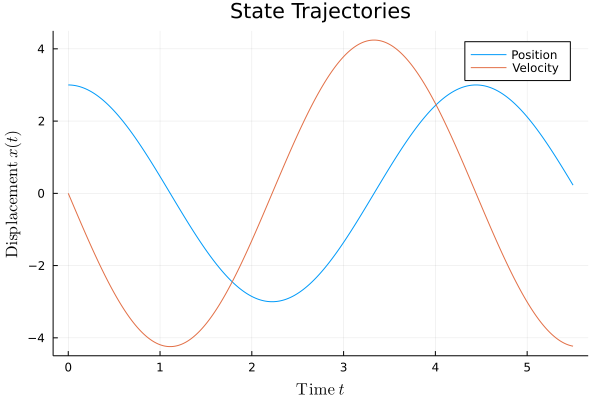

In [332]:
plot(t, solution[1,:],
        title="State Trajectories",
        label="Position",
        xlabel=L"\textrm{Time }\; t",
        ylabel=L"\textrm{Displacement }\; x(t)",
        legend=:topright
)
plot!(t, solution[2,:], label="Velocity")

To make the problem more interesting, we add some Gaussian noise to the data with a standard deviation of $\sigma = 0.1$:

In [333]:
std = 0.1
pdf = Normal(0.0, std)
noise = rand(pdf, size(solution))
solution = solution .+ noise

2×384 Matrix{Float64}:
 2.75813     2.93507    3.04556   …   0.480668   0.143744   0.352216
 0.0419284  -0.205118  -0.238479     -4.35259   -4.1944    -4.21785

After all this preliminary talk and tedious data generation, we now come to the interesting part of defining our neural potential for this problem. As you will see, Julia makes it particularly easy to define it.
We start by defining our neural network, which has one input and one output neuron as well as two hidden layers with 8 neurons each and <i>ReLU</i> activation functions.
Then we initialize the parameters of our neural network. 
As a nice sidegig, we also try to learn the initial conditions of the problem from the data.
Those are initialized from a uniform distribution centered at $3$ and $0$ respectively.

In [334]:
NN = FastChain(
    FastDense(1, 8, tanh),
    FastDense(8, 8, tanh), 
    FastDense(8, 1)
)

ps = vcat(rand(Float32, 2) .+ [2.5, -0.5], initial_params(NN))
size(ps)

(99,)

The next step is to define our differential equation again, but this time with the neural network. Not that the parameter $p$ essentially takes the role of what we called $\theta$ before. We then continue by defining our IVP again.

In [335]:
dNN(x,p) = Zygote.gradient(x -> NN(x,p)[1], x)[1]

function neuraloscillator!(du, u, p, t)
    x = u[1]
    v = u[2]

    du[1] = v
    du[2] = -dNN([x],p)[1]
end

neural_ivp = ODEProblem(neuraloscillator!, ps[1:2], tspan, ps[3:end])

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 5.5)
u0: 2-element Vector{Float64}:
  2.8425490856170654
 -0.24267125129699707

The problem is now set up and ready to go. But we realize that we are still missing some things. 
First of all, we need a cost function to quantize the difference between prediction $x_i$ and ground truth $o_i$ and prediction for every training step. We decide to loose an ordinary least squares loss (OLS), i.e.

\begin{equation}
    \cal{L} = \sum_i (x_i - o_i)^2.
\end{equation}

In Julia, it is common to calculate the loss in two steps, i.e. by using two dedicated functions. This might seem superfluous for such a simple task but as you create more complex applications, this will prove useful for debugging purposes and better code readability. Note that we only use the predictions of the positions $x_i$ for the learning procedure and chose to ignore the velocities.

In [336]:
 # Function that predicts the results for a given set of parameters by solving the ODE at the time-steps
function predict(params)
    return Array(solve(neural_ivp, Tsit5(), u0=params[1:2], p=params[3:end], saveat=t))
end

# Function that calculates the loss with respect to the ground truth
function loss(params)
    pred = predict(params)
    return sum(abs2, pred[1,:] .- solution[1,:])
end

loss (generic function with 1 method)

Now, only one building block is missing - the optimizer. As of today, most deep learning applications use the ADAM optimizer or a version of it. We do not want to stray from this tradition and thus use it as well with an initial learning rate of $0.1$.

In [337]:
opt = ADAM(0.1)

ADAM(0.1, (0.9, 0.999), IdDict{Any, Any}())

Now it is time to train the model. This is done with a single call to the following method. We train the model for 1000 iterations with the given cost function and parameters.
The macro ``` @time ``` measures the execution time of the training. With a reasonably good CPU, the training should be only a matter of minutes.

In [338]:
@time result =  DiffEqFlux.sciml_train(loss, ps, opt, maxiters=2500)

301.139292 seconds (1.16 G allocations: 658.865 GiB, 19.24% gc time, 1.94% compilation time)


u: 99-element Vector{Float64}:
  2.970603732841635
  0.013767725804855836
  0.05182215343146047
 -1.0479131230939005
 -0.8819622236261023
 -0.4996292015769781
  0.5444601379636133
 -0.7839051813459178
 -1.1974533974810817
 -0.7294051302834204
 -1.0088697773091706
 -2.864343507510072
 -2.0850582559830433
  ⋮
  0.08196210768837787
 -0.8872640167322938
  0.816870808128843
  1.1762866123861186
 -2.0658028410172515
  2.640691225337759
 -1.159411931254404
 -1.4479335220179081
 -0.9088478816353239
 -0.10852012065398212
 -1.308530558872998
  0.0

The resulting best-fit parameters can be used to evaluate the model and obtain an estimate for the potential. The first two parameters are estimates for the initial conditions and are pretty close to the ones we chose to generate the data.

In [339]:
result.minimizer[1:2]

2-element Vector{Float64}:
 2.970603732841635
 0.013767725804855836

The solution for the best-fit parameters is obtained through solving the ODE again. We can plot the results over the generated synthetic data.

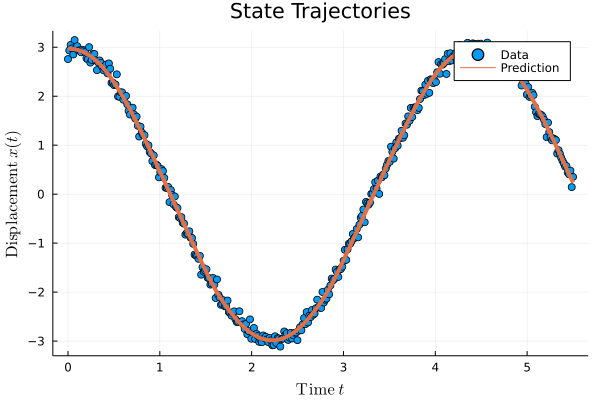

In [340]:
bestfit = Array(solve(neural_ivp, Tsit5(), u0=result.minimizer[1:2], p=result.minimizer[3:end], saveat=t))

scatter(t, solution[1,:],
        title="State Trajectories",
        label="Data",
        xlabel=L"\textrm{Time }\; t",
        ylabel=L"\textrm{Displacement }\; x(t)",
        legend=:topright
)
plot!(t, bestfit[1,:], label="Prediction", linewidth=4)

By using a list comprehension, we can obtain the potential for interval $[-3, 3]$. A larger interval is not meaningful because there is no training data available. We center the data by substracting the value of the neural network at $0$. This corresponds to making use of the fact that we can always redefine our energy scale by adding a constant.

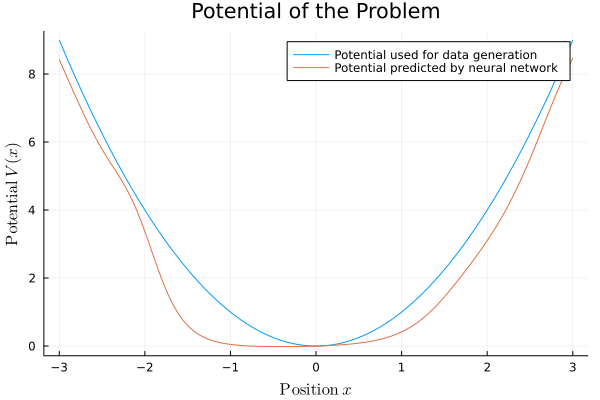

In [343]:
xrange = Array(range(-3.0, 3.0, length=100))
potential = [NN([x], result.minimizer[3:end])[1] for x ∈ xrange] .- NN([0.0], result.minimizer[3:end])[1]

plot(xrange, 0.5*D.*xrange.^2, 
        title="Potential of the Problem",
        label="Potential used for data generation",
        xlabel=L"\textrm{Position }\; x",
        ylabel=L"\textrm{Potential }\; V(x)",
        legend=:topright
)
plot!(xrange, potential, label="Potential predicted by neural network")

As we can see, the trajectory and potential are predicted with satisfactory precision. By increasing the iterations and tuning the learning rate, one could certainly obtain even better results. Now that we have seen, that the idea works very well, let us discuss the results a little.<br>
First of all, we can now interpret the neural network in terms of a physical quantity, i.e. the neural network is nothing else than the potential of the problem. Thus it defines the physics of our system.<br>
Secondly, by assuming the existence of a potential, we implicitly assume conservation of energy. Thus, we have directly implemented energy conservation into our model. This leverages a problem that many other approaches like RNNs and LSTMs have. They are not able to grasp such concepts like conservation laws.
Finally, the ability to explicitly implement such physical priors allows to make much more reliable predictions:

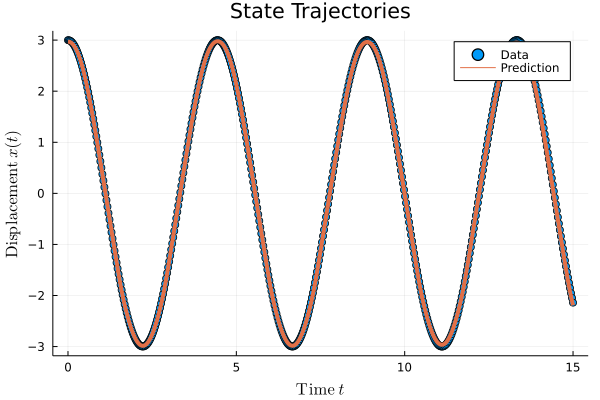

In [350]:
extended_tspan = (0.0, 15.0)
extended_t = Array(range(0.0, 15.0, length=500))

extended_ivp = ODEProblem(oscillator!, u0, extended_tspan, p)
extended_neural_ivp = ODEProblem(neuraloscillator!, ps[1:2], extended_tspan, ps[3:end])

data = Array(solve(extended_ivp, Tsit5(), u0=u0, p=p, saveat=extended_t))
prediction = Array(solve(extended_neural_ivp, Tsit5(), u0=result.minimizer[1:2], p=result.minimizer[3:end], saveat=extended_t))

scatter(extended_t, data[1,:],
        title="State Trajectories",
        label="Data",
        xlabel=L"\textrm{Time }\; t",
        ylabel=L"\textrm{Displacement }\; x(t)",
        legend=:topright
)
plot!(extended_t, prediction[1,:], label="Prediction", linewidth=4)

We see that even though we have trained the model only on the interval $[0,6]$, it is able to generalize far beyond that region.

## Part Four - Summary

As we have seen, the method of neural potentials offers a new way to analyze dynamical systems in a physically sound way that allows to interpret all the components and makes it explicitly how priors are implemented.
Additionally, the method is powerful in making reliable predictions for the far future.
However, the most important feature is its ability to facilitate the approach that we call <b>data-driven theoretical physics research</b>.
What is that you may ask?<br>
The idea of neural potentials is that we let the data dictate how certain unknown quantities like the potential for a certain system have to look like. Apart from ideas that we know to hold true from other findings and experiments, we do not put any prior assumptions into the model. This is especially interesting as it allows the quantity to be unbiased to a certain degree. There is still a certain bias due to the following reasons:
- Choice of the range and distribution of initial conditions
- Neglect of certain, possibly important effects
- Choice of activation functions and number of layers
- Choice of the cost function and regularizations

In addition to that, there are other, more systematic problems with this approach:

1. It can only be used for energy conserving systems.
2. It requires a system of coupled ordinary differential equations (partial differential equations are not possible for example).
3. It suffers from the curse of high dimension in the sense that for higher-dimensional problems, e.g. a particle moving in all three dimensions requires a lot more points to make a reliable prediction up to the point where data generation by experiments becomes unfeasible.
Still, most of these problems can be at least partially resolved.
For example, the approach can be extended to other concepts, for example neural equations of states for fluids or even entire neural Lagrange functions.
Also, in physics we often deal with idealized systems that have already been dramatically optimized such that there are only few independent variables and very often, these systems are described by coupled ODEs. Examples are:
- Friedmann equation of cosmology which describe the evolution of our Universe (explored in my Master's thesis)
- Celestial mechanics and two-body problem (also explored in my Master's thesis)
- Laminar flows in tubes
- Certain problems of electro- and magnetostatics
- Problems from quantum physics such as the harmonic oscillator, particle-in-a-box or even the hydrogen atom.

All in all there is still much to do and a lot of problems to explore.

<b> Have fun and enjoy! </b>